Questo è un tentativo di escludere Wikipedia da tutta l'analisi. Infatti, come ho notato facendo degli esempi, sebbene dovrebbe essere la fonte meno "imparziale", il fatto che gli articoli abbiano soggetti abbastanza differenti rispetto al resto delle testate giornalistiche potrebbe inficiare sui risultati.

# Libraries

In [61]:
# General purpose
import pandas as pd
import os
import glob
import json
import numpy as np
from ast import literal_eval
import string
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine
import itertools
from numpy.linalg import norm
from collections import Counter
import codecs
import tqdm
import scipy as sp
from joblib import dump, load
# NLP
from cade.cade import CADE
from gensim.models.word2vec import Word2Vec
# Machine Learning
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.model_selection import cross_val_score
# currently installed theme will be used to
# set plot style if no arguments provided
# Theme
from jupyterthemes import jtplot
jtplot.style()

In [2]:
# Function to remove punctuation from strings.
# Copied from Prof.
def simple_preproc(text):
  """
  see: https://stackoverflow.com/questions/265960/best-way-to-strip-punctuation-from-a-string
  """
  return text.translate(str.maketrans('', '', string.punctuation))

# Pre-processing

In [3]:
def create_newssite(link = None):
        if link is np.nan:
            return("Wikipedia")
        elif "slate.com" in link:
            return("Slate")
        elif "https://www.nytimes.com" in link:
            return("New York Times")
        elif "https://www.breitbart.com" in link:
            return("Breitbart")
        elif "https://www.cnn.com" in link:
            return("CNN")
        elif "abcnews" in link:
            return("ABC News")
        elif "https://thefederalist.com" in link:
            return("The Federalist")
        elif "https://www.newsmax.com" in link:
            return("News Max")
        else:
            return("Unknown")

In [4]:
df_list = pd.DataFrame()
[for filename in glob.glob('./data_final_3/*.json'):
    print(filename)
    with open(filename, 'r') as f:
        json_load = json.loads(f.read())
        df_list = df_list.append(pd.DataFrame
                                 .from_records(json_load, 
                                               index="_id"), 
                                 ignore_index = True)        ]

./data_final_3/scraping_data_NYTimes.json
./data_final_3/scraping_data_Breitbart.json
./data_final_3/scraping_data_CNN.json
./data_final_3/scraping_data_ABC.json
./data_final_3/scraping_data_Federalist.json
./data_final_3/scraping_data_NewsMax.json


In [5]:
df_list = df_list[['Title', "Date", "Link", "Paragraphs", "Authors"]]

In [6]:
df_list["Newssite"] = df_list["Link"].apply(create_newssite)

if len(df_list[df_list["Newssite"][:] == "Unknown"]) == 0:
    print("AVVOCATO CI SIAMO")

AVVOCATO CI SIAMO


In [7]:
with open("./data_safe_3.csv", 'w') as file:
    df_list.to_csv(file)

# CADE

## Embedding Totale

### Pre-processing corpora

In [8]:
with open("./data_safe_3.csv") as file:
    df = pd.read_csv(file, engine='c')

df["Paragraphs"] = df["Paragraphs"].apply(literal_eval)

EVERYTHING = ""
for k in df["Paragraphs"]:
    EVERYTHING += "\n".join(k)

In [9]:
EVERYTHING = simple_preproc(EVERYTHING).lower()
EVERYTHING = EVERYTHING.replace("—", 
                                                "").replace("\n", 
                                                            " ").replace("“", 
                                                                         "").replace("“", 
                                                                                          "").replace("”", 
                                                                                                      "").replace("’s", 
                                                                                                             "")

In [10]:
with open("./EVERYTHING_3.txt", 'w') as file:
    file.write(EVERYTHING)

### Addestramento

In [11]:
aligner = CADE(size=100, workers=12)

aligner.train_compass("./EVERYTHING_3.txt", 
                      overwrite=False) # keep an eye on the overwrite behaviour

Training the compass from scratch.


## Embedding slices

In [12]:
with open("./data_safe_3.csv") as file:
    df = pd.read_csv(file, engine='c')
    
df["Paragraphs"] = df["Paragraphs"].apply(literal_eval)

for i, Newssite in enumerate(df["Newssite"].unique()):
    print("[INFO] Progress:"+str(i+1)+"/"+str(len(df["Newssite"].unique())))
    newssite_to_text = ""
    for k in df[df["Newssite"] == Newssite]["Paragraphs"][:]:
        newssite_to_text += "\n".join(k)
    newssite_to_text = simple_preproc(newssite_to_text).lower()
    newssite_to_text = newssite_to_text.replace("—", 
                                                "").replace("\n", 
                                                            " ").replace("“", 
                                                                         "").replace("“", 
                                                                                          "").replace("”", 
                                                                                                      "").replace("’s", 
                                                                                                             "")
    with open("./corpora_3/text_"+str(Newssite)+".txt", 'w') as file:
        file.write(newssite_to_text)

[INFO] Progress:1/6
[INFO] Progress:2/6
[INFO] Progress:3/6
[INFO] Progress:4/6
[INFO] Progress:5/6
[INFO] Progress:6/6


In [13]:
slices = {
            Newssite: aligner.train_slice(
                "./corpora_3/text_"+str(Newssite)+".txt", 
                save=False
                                        )
            for Newssite in df["Newssite"].unique()
         }

Training embeddings: slice ./corpora_3/text_New York Times.txt.
Initializing embeddings from compass.
Training embeddings: slice ./corpora_3/text_Breitbart.txt.
Initializing embeddings from compass.
Training embeddings: slice ./corpora_3/text_CNN.txt.
Initializing embeddings from compass.
Training embeddings: slice ./corpora_3/text_ABC News.txt.
Initializing embeddings from compass.
Training embeddings: slice ./corpora_3/text_The Federalist.txt.
Initializing embeddings from compass.
Training embeddings: slice ./corpora_3/text_News Max.txt.
Initializing embeddings from compass.


In [14]:
# Dobbiamo andare a salvare i vari slice
for my_slice in slices:
    slices[my_slice].save("models_3/"+str(my_slice)+".model")

## Visualizzazioni Medie

In [15]:
def sum_vectors(my_slice = None):
    my_sum = 0
    for i, word in enumerate(my_slice.wv.vocab):
        my_sum += my_slice.wv[word]
    return(my_sum/len(my_slice.wv.vocab))

In [16]:
my_sum = [sum_vectors(slices[my_slice]) 
       for i, my_slice in enumerate(slices)]

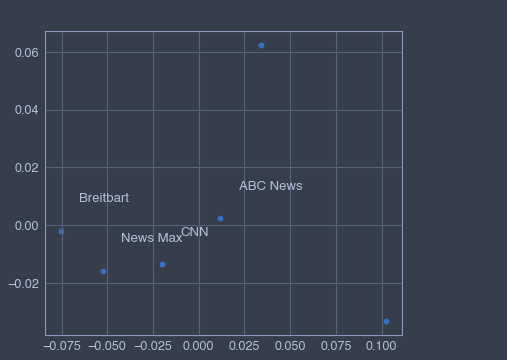

In [17]:
X_tranf = PCA(n_components=2).fit_transform(my_sum)
plt.scatter(X_tranf[:, 0], X_tranf[:, 1])
for index, word in enumerate(slices):
    plt.annotate(word, xy=(X_tranf[index, 0]+0.01, X_tranf[index, 1]+0.01))
plt.show()

# Lexicon Refinement

## Pre-processing Lexicon

Questa operazione è già stata eseguita da altre parti.

## Lexicon Refinement Pipeline

In [18]:
from utils import *

In [19]:
# Caricamento del lexicon
with open("./lexicon/clean_lexicon.csv", 'r') as file:
    lexicon = pd.read_csv(file, index_col=1)

# Caricamento dei modelli già addestrati
slices = {filename.split('/')[-1].replace(".model", ""): 
          Word2Vec.load(filename)
          for filename in glob.glob('./models_3/*.model')}

In [20]:
lexicon = lexicon.drop("Unnamed: 0", axis=1)

lexicon = lexicon.to_dict()["Subj_score"]

In [22]:
# Lessico che si ottiene raffinando su tutti 
# gli embedding generati
lexicon_refined = lexicon_refinement(lex = lexicon, 
                   models = [slices[sli] 
                             for sli in slices], 
                   corpora = ["./corpora_3/text_"+str(sli)+".txt" 
                              for sli in slices], 
                    zipf_cutoff=5)

count text_ABC News
min_count text_ABC News
zipf text_ABC News
count text_Breitbart
min_count text_Breitbart
zipf text_Breitbart
count text_CNN
min_count text_CNN
zipf text_CNN
count text_The Federalist
min_count text_The Federalist
zipf text_The Federalist
count text_New York Times
min_count text_New York Times
zipf text_New York Times
count text_News Max
min_count text_News Max
zipf text_News Max
dataframe done
common filter done


In [23]:
with open("./lexicon_3/lexicon_refined.csv", 'w') as file:
    pd.DataFrame(lexicon_refined).to_csv(file)

## Lexicon Enrichement

In [24]:
# Dobbiamo fare così per come è costruita la funzione di Nicoli
lexicon_refined[lexicon_refined == 0] = -1

In [25]:
vectorized_lexicon, lexicon_labels, words = enrich(lex = lexicon_refined, 
       models = [slices[sl] for sl in slices], 
       n_target = 400, 
       msteps = 200, 
       return_words = True)

  0%|          | 0/62 [00:00<?, ?it/s]

Balancing:  62


  1%|          | 1/192 [00:00<00:19,  9.56it/s]

Growing:  192


100%|██████████| 192/192 [03:13<00:00,  1.01s/it]


In [26]:
with open("./lexicon_3/enriched_lexicon.csv", 'w') as file:
    pd.DataFrame({"Vectorized_words": vectorized_lexicon.tolist(), 
              "Labels": lexicon_labels, "Words": words}).to_csv(file)

# Nicoli Logistic

## ML Optimization

In [27]:
# Open the pre-prepared lexicon
with open("./lexicon_3/enriched_lexicon.csv", 'r') as file:
    enriched_lexicon = pd.read_csv(file, 
                                   engine='c', 
                                   index_col=0)

In [28]:
# Read the strings as lists
enriched_lexicon["Vectorized_words"] = (enriched_lexicon["Vectorized_words"]
                                        .apply(literal_eval))

In [29]:
# Prepare a list of 100-dimension vectors (the words)
X = enriched_lexicon["Vectorized_words"].tolist()
# List of labels (1, -1)
y = enriched_lexicon["Labels"]

[]

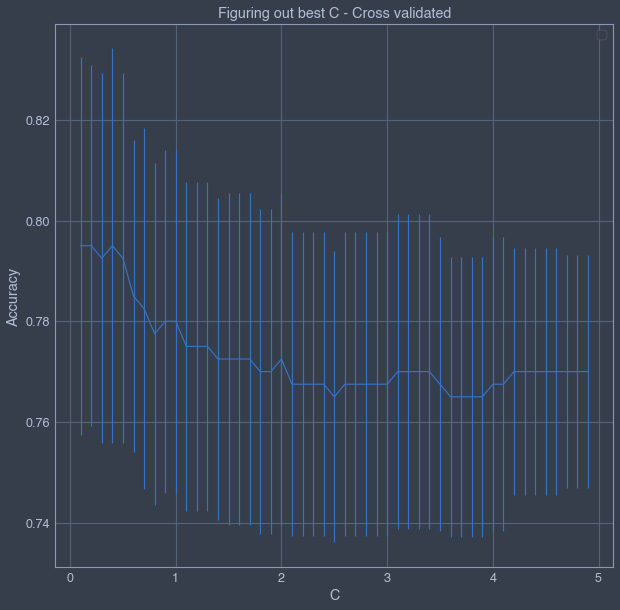

In [43]:
#tento con una cross validation e c nell'arco 0.1, 10
score_mean = []
score_stds = []
Cs = Cs = np.arange(0.1, 5, 0.1)
plt.figure(figsize=(10,10))
for c in Cs:
    clf = LogisticRegression(C=c, penalty='l2', solver='liblinear')
    scores = cross_val_score(clf, X, y, cv=5)
    score_mean.append(scores.mean())
    score_stds.append(scores.std())

plt.errorbar(Cs, score_mean, yerr = score_stds)
plt.legend()
plt.xlabel("C")
plt.ylabel("Accuracy")
plt.title("Figuring out best C - Cross validated")
plt.plot()

## Propagation

In [45]:
# Addestriamo completamente il lessico
inducer = (LogisticRegression(C=0.1, penalty='l2', solver='liblinear')
           .fit(X,y))

In [66]:
dump(inducer, "./ML_models/Nicoli_logistic_without_Wiki.joblib") 

['./ML_models/Nicoli_logistic_without_Wiki.joblib']

## Scoring Probabilistic

In [46]:
models_propagation_Hamilton = [{word: 
                       inducer.predict_proba([model.wv[word]])[0][0]
  for word in model.wv.vocab} for model in slices.values()]

vocab_counts_Hamilton = [{word: model.wv.vocab[word].count * model_prop[word]
                for word in model.wv.vocab} 
                for model, model_prop in zip(slices.values(), 
                                             models_propagation_Hamilton)]

# This is just the sum of all words in the corpus
vocab_counts_abs = [{word: abs(model.wv.vocab[word].count)
                    for word in model.wv.vocab}  
                    for model in slices.values()]
# Difatti questa misure dice quante parole soggettive ci sono
# per singola parola scritta nei vari corpus.
models_score_Hamilton = {name: sum(count.values())/(sum(count_abs.values()))
                         for name, count, count_abs in zip(slices, 
                                                           vocab_counts_Hamilton, 
                                                           vocab_counts_abs)}

In [59]:
{k: ((v - min(models_score_Hamilton.values())) 
     / (max(models_score_Hamilton.values()) - min(models_score_Hamilton.values())))
 for k, v in sorted(models_score_Hamilton.items(), 
                    key=lambda item: item[1])} 
  



{'New York Times': 0.0,
 'Breitbart': 0.5612788839875347,
 'CNN': 0.6506592249084002,
 'News Max': 0.651698953913649,
 'ABC News': 0.703204240991167,
 'The Federalist': 1.0}

# No propagation

## Scoring

In [47]:
# Load as dictionary the refined lexicon
with open("./lexicon_3/lexicon_refined.csv", 'r') as file:
    lexicon_refined = pd.read_csv(file, index_col=0).to_dict()["Valence"]

In [51]:
models_propagation_none = [{word: 
                       (lexicon_refined[word]+1)/2
  for word in lexicon_refined} for model in slices.values()]

vocab_counts_none = [{word: model.wv.vocab[word].count * model_prop[word]
                for word in lexicon_refined} 
                for model, model_prop in zip(slices.values(), models_propagation_none)]

# This is just the sum of all words in the corpus
vocab_counts_abs = [{word: abs(model.wv.vocab[word].count)
                    for word in model.wv.vocab}  
                    for model, model_prop in zip(slices.values(), 
                                                 models_propagation_none)]
# Difatti questa misure dice quante parole soggettive ci sono
# per singola parola scritta nei vari corpus.
models_score_none = {name: sum(count.values())/(sum(count_abs.values()))
                for name, count, count_abs in zip(slices, vocab_counts_none, 
                                            vocab_counts_abs)}

In [58]:
{k: ((v - min(models_score_none.values())) 
     / (max(models_score_none.values()) - min(models_score_none.values())))
 for k, v in sorted(models_score_none.items(), 
                    key=lambda item: item[1])} 
  


{'Breitbart': 0.0,
 'New York Times': 0.030847987360217648,
 'CNN': 0.4855827384612681,
 'The Federalist': 0.7530735958285493,
 'News Max': 0.8018595673409725,
 'ABC News': 1.0}